In [40]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
pd.set_option("display.max_columns", 180)
from tqdm.notebook import tqdm
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
def normalize(data):
    df=data.copy()
    for column in df.columns[8:]:
        minim = df[column].min()
        maxim = df[column].max()
        df[column] = (df[column] - minim) / (maxim - minim)
    return df

In [42]:
def compute_similarity(data, player, min_minutes=100):
    df = data[data.minutesPlayed>=min_minutes].reset_index(drop=True)
    df = normalize(df)
    j = df[df['playerId']==player].index.values[0]    
    similarity = df.copy()
    for row in range(0,len(df)):
        for column in df.columns[8:]:
            similarity.at[row,column] = abs(df.loc[row,column] - df.loc[j,column])
            
    similarity['Distance']= similarity.iloc[:,8:].mean(axis=1) 
    similarity['SimilarityIndex'] = round((1 - similarity['Distance'])*100, 3)
    similarity = similarity[['playerId', 
                             'shortName', 
                             'team', 
                             'position', 
                             'height', 
                             'foot', 
                             'minutesPlayed', 
                             'SimilarityIndex']]
    similarity = similarity.sort_values(by='SimilarityIndex', ascending=False).iloc[1:,:].reset_index(drop=True)
    return similarity

In [43]:
def distance_to_clone(df1,df2, player):
    print(color.BOLD + '\n Number of players in consideration for computing D2C: {}'.format(df2.shape[0]) + color.END)    
    half2 = df2.copy()
    half2['playerId'].replace(player,9999, inplace=True)
    half2 = half2.append(df1[df1['playerId']==player], ignore_index=True)
    
    half2 = normalize(half2)
    similarity = compute_similarity(half2, player)
    distance = similarity[similarity['playerId']==9999].index.values[0]    
    print(color.BOLD + "\n {}'s Distance2Clone is {}".format(df2[df2['playerId']==player]['shortName'].iloc[0], \
                                                        distance) + color.END) 
    
    print("\n The players from H1 who are most similar to {} (from H2) are:".format(df2[df2['playerId']==player]['shortName'].iloc[0]))
    if distance<10:
        display.display(similarity.head(5))
    else:
        display.display(similarity.head(distance+1))  

In [49]:
H1 = pd.read_csv('final_data/H1_random.csv')
H2 = pd.read_csv('final_data/H2_random.csv')
df = pd.read_csv('final_data/full_data.csv')

## Find the Distance2Clone of a given player (all players in data set considered)

In [6]:
distance_to_clone(H1, H2, 3359)


 Number of players in consideration for computing D2C: 2216

 L. Messi's Distance2Clone is 0

 The players from H1 who are most similar to L. Messi (from H2) are:


,playerId,shortName,team,position,height,foot,minutesPlayed,SimilarityIndex
0,9999,L. Messi,Barcelona,Forward,170,left,1223,93.268
1,20820,J. Ilicic,Atalanta,Forward,190,left,1118,89.857
2,89186,P. Dybala,Juventus,Forward,177,left,1120,89.380
3,3314,A. di Maria,PSG,Midfielder,180,left,1062,89.235
4,7873,J. Wilshere,West Ham United,Midfielder,172,left,645,88.998


## Find the Distance2Clone of all players

In [44]:
def find_distance(df1, df2, player):
    h1 = df1.copy()
    half2 = df2.copy()
    half2['playerId'].replace(player,9999, inplace=True)
    half2 = half2.append(h1[h1['playerId']==player], ignore_index=True)
    half2 = normalize(half2)
    similarity = compute_similarity(half2, player)
    
    distance = similarity[similarity['playerId']==9999].index.values[0]
    
    print(color.BOLD + "{}'s distance to his clone is {}".format(df2[df2['playerId']==player]['shortName'].iloc[0], \
                                                        distance) + color.END)
    return distance

In [45]:
def Distance2Clone_results(df, df1, df2):
    distance_to_clone = sample.copy()
    distance_to_clone['DTC']=0
    distance_to_clone['MostSimilar']=0
    distance_to_clone['AverageSimilarity']=0
    half1 = df1.reset_index(drop=True)
    half2 = df2.reset_index(drop=True)
    
    players=[]; d2c=[]
    for playerId in half2.playerId:
        i = half2[half2['playerId']==playerId].index.values[0]
        print(color.DARKCYAN + '\nPlayer {} of {}'.format(i+1, half2.shape[0]) + color.END)
        if ((playerId in list(half2.playerId.unique())) & (playerId in list(half1.playerId.unique()))):
            try:
                distance = find_distance(half1, half2, playerId)
                players.append(playerId)
                d2c.append(distance)
            except: continue
        else:
            players.append(playerId)
            d2c.append(0.99)
    Distance2Clone = pd.DataFrame()
    Distance2Clone['playerId']=players
    Distance2Clone['Distance2Clone']=d2c
    Distance2Clone = Distance2Clone[Distance2Clone.Distance2Clone!=0.99].reset_index(drop=True)
    Distance2Clone = Distance2Clone.merge(df[['playerId', 'shortName', 'team', 'position']], on='playerId', how='left')
     
    return Distance2Clone

In [46]:
def test_results(distance2clone):
    top_1 = len(distance2clone[distance2clone.Distance2Clone<=0]) / len(distance2clone)
    top_3 = len(distance2clone[distance2clone.Distance2Clone<=2]) / len(distance2clone)
    top_5 = len(distance2clone[distance2clone.Distance2Clone<=4]) / len(distance2clone)
    top_10 = len(distance2clone[distance2clone.Distance2Clone<=9]) / len(distance2clone)
    distance2clone['MRR_ind'] = 1 / (distance2clone['Distance2Clone']+1)
    MRR = distance2clone['MRR_ind'].sum() / len(distance2clone)
    print(color.BOLD + "Top-1 %: {}".format(top_1) + color.END)
    print(color.BOLD + "Top-3 %: {}".format(top_3) + color.END)
    print(color.BOLD + "Top-5 %: {}".format(top_5) + color.END)
    print(color.BOLD + "Top-10 %: {}".format(top_10) + color.END)
    print(color.BOLD + "Mean-Reciprocal-Rank (MRR): {}".format(MRR) + color.END)

We need to reduce the datasets so that the 741 who played more minutes remain.

In [50]:
sample = df.sort_values(by='minutesPlayed', ascending=False).reset_index(drop=True)

In [51]:
sample = sample.iloc[:741,:]

In [52]:
players_list = list(sample.playerId.unique())

In [53]:
H1_reduced = H1[H1.playerId.isin(players_list)]
H2_reduced = H2[H2.playerId.isin(players_list)]

In [54]:
len(H2_reduced)

741

In [55]:
results_D2C = Distance2Clone_results(df, H1_reduced, H2_reduced)


Player 1 of 741
J. Vertonghen's distance to his clone is 2

Player 2 of 741
C. Eriksen's distance to his clone is 0

Player 3 of 741
N. Moisander's distance to his clone is 24

Player 4 of 741
J. Guomundsson's distance to his clone is 0

Player 5 of 741
Marcelo's distance to his clone is 0

Player 6 of 741
E. Pieters's distance to his clone is 0

Player 7 of 741
K. Strootman's distance to his clone is 0

Player 8 of 741
G. Wijnaldum's distance to his clone is 0

Player 9 of 741
M. Depay's distance to his clone is 0

Player 10 of 741
D. Mertens's distance to his clone is 1

Player 11 of 741
S. de Vrij's distance to his clone is 0

Player 12 of 741
J. Gouweleeuw's distance to his clone is 9

Player 13 of 741
R. van La Parra's distance to his clone is 10

Player 14 of 741
R. Rosales's distance to his clone is 0

Player 15 of 741
V. van Dijk's distance to his clone is 0

Player 16 of 741
D. Tadic's distance to his clone is 0

Player 17 of 741
B. Nuytinck's distance to his clone is 0

Play

Borja Garcia's distance to his clone is 0

Player 111 of 741
David Lopez's distance to his clone is 0

Player 112 of 741
Juanpe's distance to his clone is 0

Player 113 of 741
Dani Castellano's distance to his clone is 12

Player 114 of 741
Jonathan Viera's distance to his clone is 0

Player 115 of 741
Jonny's distance to his clone is 0

Player 116 of 741
Saul's distance to his clone is 0

Player 117 of 741
Daniel Carvajal's distance to his clone is 1

Player 118 of 741
Arbilla's distance to his clone is 0

Player 119 of 741
Jose Gaya's distance to his clone is 19

Player 120 of 741
Mariano Diaz's distance to his clone is 3

Player 121 of 741
A. Nyom's distance to his clone is 5

Player 122 of 741
Gerard Moreno's distance to his clone is 0

Player 123 of 741
Luis Hernandez's distance to his clone is 0

Player 124 of 741
Dani Garcia's distance to his clone is 0

Player 125 of 741
Zaldua's distance to his clone is 0

Player 126 of 741
Eraso's distance to his clone is 1

Player 127 of 741

A. Hunt's distance to his clone is 0

Player 220 of 741
H. Badstuber's distance to his clone is 2

Player 221 of 741
Luiz Gustavo's distance to his clone is 1

Player 222 of 741
T. Kroos's distance to his clone is 0

Player 223 of 741
M. Gomez's distance to his clone is 2

Player 224 of 741
N. Petersen's distance to his clone is 0

Player 225 of 741
A. Rudiger's distance to his clone is 5

Player 226 of 741
G. Sakai's distance to his clone is 0

Player 227 of 741
C. Gentner's distance to his clone is 103

Player 228 of 741
B. Oczipka's distance to his clone is 0

Player 229 of 741
O. Toprak's distance to his clone is 0

Player 230 of 741
M. Hummels's distance to his clone is 0

Player 231 of 741
L. Piszczek's distance to his clone is 3

Player 232 of 741
M. Bakalorz's distance to his clone is 0

Player 233 of 741
S. Bender's distance to his clone is 2

Player 234 of 741
I. Perisic's distance to his clone is 0

Player 235 of 741
R. Lewandowski's distance to his clone is 1

Player 236 of

A. Masiello's distance to his clone is 0

Player 328 of 741
F. Peluso's distance to his clone is 0

Player 329 of 741
G. Bonaventura's distance to his clone is 0

Player 330 of 741
L. Cigarini's distance to his clone is 1

Player 331 of 741
D. Astori's distance to his clone is 11

Player 332 of 741
R. Nainggolan's distance to his clone is 0

Player 333 of 741
P. Schiattarella's distance to his clone is 1

Player 334 of 741
L. De Silvestri's distance to his clone is 0

Player 335 of 741
Felipe's distance to his clone is 14

Player 336 of 741
M. Nastasic's distance to his clone is 0

Player 337 of 741
Romulo's distance to his clone is 0

Player 338 of 741
A. Ljajic's distance to his clone is 0

Player 339 of 741
E. Hysaj's distance to his clone is 0

Player 340 of 741
A. Gomez's distance to his clone is 0

Player 341 of 741
D. D'Ambrosio's distance to his clone is 4

Player 342 of 741
K. Glik's distance to his clone is 0

Player 343 of 741
A. Ogbonna's distance to his clone is 0

Player 

J. Martin's distance to his clone is 0

Player 436 of 741
I. Traore's distance to his clone is 4

Player 437 of 741
N. Sliti's distance to his clone is 0

Player 438 of 741
S. Sane's distance to his clone is 2

Player 439 of 741
T. Mangani's distance to his clone is 0

Player 440 of 741
P. Gouano's distance to his clone is 0

Player 441 of 741
M. Le Marchand's distance to his clone is 34

Player 442 of 741
J. Rivierez's distance to his clone is 3

Player 443 of 741
R. Mahrez's distance to his clone is 0

Player 444 of 741
D. Sidibe's distance to his clone is 0

Player 445 of 741
V. Manceau's distance to his clone is 6

Player 446 of 741
N. Pallois's distance to his clone is 1

Player 447 of 741
A. Mandi's distance to his clone is 1

Player 448 of 741
R. Amalfitano's distance to his clone is 0

Player 449 of 741
L. Deaux's distance to his clone is 6

Player 450 of 741
G. Kakuta's distance to his clone is 0

Player 451 of 741
D. Da Silva's distance to his clone is 0

Player 452 of 741
G.

D. Zapata's distance to his clone is 3

Player 544 of 741
L. Castro's distance to his clone is 0

Player 545 of 741
G. Pezzella's distance to his clone is 0

Player 546 of 741
L. Ocampos's distance to his clone is 0

Player 547 of 741
J. Palomino's distance to his clone is 1

Player 548 of 741
P. Dybala's distance to his clone is 0

Player 549 of 741
C. Aranguiz's distance to his clone is 0

Player 550 of 741
E. Pulgar's distance to his clone is 0

Player 551 of 741
J. Izquierdo's distance to his clone is 0

Player 552 of 741
J. Mojica's distance to his clone is 0

Player 553 of 741
J. Holebas's distance to his clone is 6

Player 554 of 741
K. Manolas's distance to his clone is 1

Player 555 of 741
Antunes's distance to his clone is 1

Player 556 of 741
D. Siovas's distance to his clone is 0

Player 557 of 741
H. Sakai's distance to his clone is 0

Player 558 of 741
M. Konate's distance to his clone is 1

Player 559 of 741
B. Bereszynski's distance to his clone is 0

Player 560 of 741


Joan Jordan's distance to his clone is 0

Player 652 of 741
N. Pepe's distance to his clone is 0

Player 653 of 741
Samir's distance to his clone is 0

Player 654 of 741
Luiz Araujo's distance to his clone is 0

Player 655 of 741
Djene's distance to his clone is 1

Player 656 of 741
D. Yedlin's distance to his clone is 1

Player 657 of 741
A. Correa's distance to his clone is 0

Player 658 of 741
J. Lerma's distance to his clone is 7

Player 659 of 741
Kwon Chang-Hoon's distance to his clone is 2

Player 660 of 741
D. Cataldi's distance to his clone is 8

Player 661 of 741
Thiago Maia's distance to his clone is 2

Player 662 of 741
D. Sanchez's distance to his clone is 1

Player 663 of 741
L. Klostermann's distance to his clone is 0

Player 664 of 741
V. Rongier's distance to his clone is 18

Player 665 of 741
Pablo Maffeo's distance to his clone is 0

Player 666 of 741
F. Vicari's distance to his clone is 30

Player 667 of 741
A. Ferrari's distance to his clone is 9

Player 668 of 741

In [56]:
test_results(results_D2C)

Top-1 %: 0.6194331983805668
Top-3 %: 0.8070175438596491
Top-5 %: 0.8704453441295547
Top-10 %: 0.9284750337381916
Mean-Reciprocal-Rank (MRR): 0.7290847798280419


In [57]:
results_D2C.to_csv('final_data/results/distance2clone.csv', index=False)

Text(0.5, 0, 'Distance2Clone')

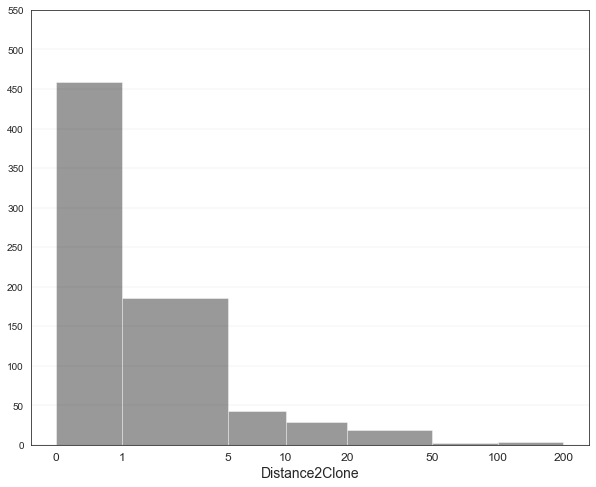

In [107]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,8))
ax= sns.distplot(np.log(results_D2C['Distance2Clone']+1), bins=([np.log(0+1),np.log(1+1),np.log(5+1),np.log(10+1),np.log(20+1),np.log(50+1),np.log(100+1),np.log(200+1)]), 
                 kde=False, color='black')
ax.grid(color='black', linestyle='-', linewidth=0.05, axis='y')
#plt.xscale("log")
ax.set_xticks([np.log(0+1),np.log(1+1),np.log(5+1), np.log(10+1),np.log(20+1),np.log(50+1),np.log(100+1),np.log(200+1)])
ax.set_xticklabels((0,1,5,10,20,50, 100,200), fontsize=12)
ax.set_yticks(np.arange(0,600,50))
ax.set_xlabel('Distance2Clone', fontsize=14)

If we divide the two halves of the data temporarily rather than random (1st Half vs 2nd Half of the season)...

In [123]:
H1_alt = pd.read_csv('final_data/H1_temporal.csv')
H2_alt = pd.read_csv('final_data/H2_temporal.csv')

In [131]:
H1_alt.drop_duplicates('playerId', inplace=True)
H2_alt.drop_duplicates('playerId', inplace=True)

In [136]:
H1_reduced = H1_alt[H1_alt.playerId.isin(players_list)]
H2_reduced = H2_alt[H2_alt.playerId.isin(players_list)]

In [117]:
len(H2_reduced)

741

In [120]:
results_D2C_alternative = Distance2Clone_results(df, H1_reduced, H2_reduced)


Player 1 of 741
J. Vertonghen's distance to his clone is 0

Player 2 of 741
C. Eriksen's distance to his clone is 0

Player 3 of 741
N. Moisander's distance to his clone is 34

Player 4 of 741
J. Guðmundsson's distance to his clone is 24

Player 5 of 741
Marcelo's distance to his clone is 3

Player 6 of 741
E. Pieters's distance to his clone is 8

Player 7 of 741
K. Strootman's distance to his clone is 0

Player 8 of 741
G. Wijnaldum's distance to his clone is 1

Player 9 of 741
M. Depay's distance to his clone is 3

Player 10 of 741
D. Mertens's distance to his clone is 0

Player 11 of 741
S. de Vrij's distance to his clone is 1

Player 12 of 741
J. Gouweleeuw's distance to his clone is 4

Player 13 of 741
R. van La Parra's distance to his clone is 0

Player 14 of 741
R. Rosales's distance to his clone is 0

Player 15 of 741
V. van Dijk's distance to his clone is 34

Player 16 of 741
D. Tadić's distance to his clone is 8

Player 17 of 741
B. Nuytinck's distance to his clone is 30

Pl

Borja García's distance to his clone is 0

Player 111 of 741
David López's distance to his clone is 8

Player 112 of 741
Juanpe's distance to his clone is 10

Player 113 of 741
Dani Castellano's distance to his clone is 45

Player 114 of 741
Jonathan Viera's distance to his clone is 12

Player 115 of 741
Jonny's distance to his clone is 0

Player 116 of 741
Saúl's distance to his clone is 0

Player 117 of 741
Daniel Carvajal's distance to his clone is 1

Player 118 of 741
Arbilla's distance to his clone is 0

Player 119 of 741
José Gayá's distance to his clone is 0

Player 120 of 741
Mariano Díaz's distance to his clone is 9

Player 121 of 741
A. Nyom's distance to his clone is 19

Player 122 of 741
Gerard Moreno's distance to his clone is 0

Player 123 of 741
Luis Hernández's distance to his clone is 0

Player 124 of 741
Dani García's distance to his clone is 0

Player 125 of 741
Zaldúa's distance to his clone is 5

Player 126 of 741
Eraso's distance to his clone is 11

Player 127 of 

N. Füllkrug's distance to his clone is 0

Player 219 of 741
A. Hunt's distance to his clone is 0

Player 220 of 741
H. Badstuber's distance to his clone is 72

Player 221 of 741
Luiz Gustavo's distance to his clone is 0

Player 222 of 741
T. Kroos's distance to his clone is 0

Player 223 of 741
M. Gómez's distance to his clone is 0

Player 224 of 741
N. Petersen's distance to his clone is 0

Player 225 of 741
A. Rüdiger's distance to his clone is 3

Player 226 of 741
G. Sakai's distance to his clone is 366

Player 227 of 741
C. Gentner's distance to his clone is 95

Player 228 of 741
B. Oczipka's distance to his clone is 1

Player 229 of 741
Ö. Toprak's distance to his clone is 3

Player 230 of 741
M. Hummels's distance to his clone is 0

Player 231 of 741
L. Piszczek's distance to his clone is 2

Player 232 of 741
M. Bakalorz's distance to his clone is 3

Player 233 of 741
S. Bender's distance to his clone is 0

Player 234 of 741
I. Perisić's distance to his clone is 0

Player 235 of 

J. Iličić's distance to his clone is 6

Player 327 of 741
A. Masiello's distance to his clone is 1

Player 328 of 741
F. Peluso's distance to his clone is 9

Player 329 of 741
G. Bonaventura's distance to his clone is 0

Player 330 of 741
L. Cigarini's distance to his clone is 7

Player 331 of 741
D. Astori's distance to his clone is 0

Player 332 of 741
R. Nainggolan's distance to his clone is 0

Player 333 of 741
P. Schiattarella's distance to his clone is 12

Player 334 of 741
L. De Silvestri's distance to his clone is 1

Player 335 of 741
Felipe's distance to his clone is 1

Player 336 of 741
M. Nastasić's distance to his clone is 12

Player 337 of 741
Rômulo's distance to his clone is 0

Player 338 of 741
A. Ljajić's distance to his clone is 0

Player 339 of 741
E. Hysaj's distance to his clone is 0

Player 340 of 741
A. Gómez's distance to his clone is 0

Player 341 of 741
D. D'Ambrosio's distance to his clone is 226

Player 342 of 741
K. Glik's distance to his clone is 0

Player

S. Falette's distance to his clone is 17

Player 435 of 741
J. Martin's distance to his clone is 1

Player 436 of 741
I. Traoré's distance to his clone is 2

Player 437 of 741
N. Sliti's distance to his clone is 0

Player 438 of 741
S. Sané's distance to his clone is 0

Player 439 of 741
T. Mangani's distance to his clone is 0

Player 440 of 741
P. Gouano's distance to his clone is 0

Player 441 of 741
M. Le Marchand's distance to his clone is 60

Player 442 of 741
J. Rivierez's distance to his clone is 16

Player 443 of 741
R. Mahrez's distance to his clone is 0

Player 444 of 741
D. Sidibé's distance to his clone is 0

Player 445 of 741
V. Manceau's distance to his clone is 0

Player 446 of 741
N. Pallois's distance to his clone is 1

Player 447 of 741
A. Mandi's distance to his clone is 1

Player 448 of 741
R. Amalfitano's distance to his clone is 3

Player 449 of 741
L. Deaux's distance to his clone is 13

Player 450 of 741
G. Kakuta's distance to his clone is 0

Player 451 of 741


G. Mercado's distance to his clone is 55

Player 543 of 741
D. Zapata's distance to his clone is 1

Player 544 of 741
L. Castro's distance to his clone is 0

Player 545 of 741
G. Pezzella's distance to his clone is 2

Player 546 of 741
L. Ocampos's distance to his clone is 0

Player 547 of 741
J. Palomino's distance to his clone is 1

Player 548 of 741
P. Dybala's distance to his clone is 0

Player 549 of 741
C. Aránguiz's distance to his clone is 0

Player 550 of 741
E. Pulgar's distance to his clone is 0

Player 551 of 741
J. Izquierdo's distance to his clone is 0

Player 552 of 741
J. Mojica's distance to his clone is 1

Player 553 of 741
J. Holebas's distance to his clone is 0

Player 554 of 741
K. Manolas's distance to his clone is 0

Player 555 of 741
Antunes's distance to his clone is 1

Player 556 of 741
D. Siovas's distance to his clone is 0

Player 557 of 741
H. Sakai's distance to his clone is 68

Player 558 of 741
M. Konaté's distance to his clone is 0

Player 559 of 741
B.

Iñaki Williams's distance to his clone is 0

Player 651 of 741
Joan Jordán's distance to his clone is 6

Player 652 of 741
N. Pépé's distance to his clone is 6

Player 653 of 741
Samir's distance to his clone is 0

Player 654 of 741
Luiz Araújo's distance to his clone is 0

Player 655 of 741
Djené's distance to his clone is 0

Player 656 of 741
D. Yedlin's distance to his clone is 2

Player 657 of 741
Á. Correa's distance to his clone is 9

Player 658 of 741
J. Lerma's distance to his clone is 6

Player 659 of 741
Kwon Chang-Hoon's distance to his clone is 3

Player 660 of 741
D. Cataldi's distance to his clone is 21

Player 661 of 741
Thiago Maia's distance to his clone is 0

Player 662 of 741
D. Sánchez's distance to his clone is 15

Player 663 of 741
L. Klostermann's distance to his clone is 165

Player 664 of 741
V. Rongier's distance to his clone is 0

Player 665 of 741
Pablo Maffeo's distance to his clone is 0

Player 666 of 741
F. Vicari's distance to his clone is 1

Player 667 

In [121]:
test_results(results_D2C_alternative)

Top-1 %: 0.4966261808367072
Top-3 %: 0.6734143049932524
Top-5 %: 0.7341430499325237
Top-10 %: 0.8029689608636977
Mean-Reciprocal-Rank (MRR): 0.6086155250105059


In [122]:
results_D2C_alternative.to_csv('final_data/results/distance2clone_temporal_division.csv', index=False)

In [128]:
results_D2C_alternative = pd.read_csv('final_data/results/distance2clone_temporal_division.csv')

In [132]:
test_results(results_D2C_alternative)

Top-1 %: 0.4966261808367072
Top-3 %: 0.6734143049932524
Top-5 %: 0.7341430499325237
Top-10 %: 0.8029689608636977
Mean-Reciprocal-Rank (MRR): 0.6086155250105059


In [134]:
results_D2C_alternative.rename(columns={'Distance2Clone': 'Distance2Clone_temporal'}, inplace=True)

In [137]:
len(results_D2C)

741

In [136]:
results_D2C = results_D2C.merge(results_D2C_alternative[['playerId', 'Distance2Clone_temporal']], on='playerId', how='left')

In [141]:
results_D2C['diff'] = abs(results_D2C.Distance2Clone - results_D2C.Distance2Clone_temporal)

In [145]:
results_D2C['diff'].describe()

count    741.000000
mean       9.770580
std       28.352582
min        0.000000
25%        0.000000
50%        1.000000
75%        8.000000
max      366.000000
Name: diff, dtype: float64

In [152]:
np.percentile(results_D2C['diff'], np.arange(0,100,10))

array([ 0.,  0.,  0.,  0.,  1.,  1.,  2.,  5., 11., 24.])

In [139]:
results_D2C.Distance2Clone.corr(results_D2C.Distance2Clone_temporal)

0.22748681378581384

In [144]:
results_D2C

,playerId,Distance2Clone,shortName,team,position,MRR_ind,Distance2Clone_temporal,diff
0,48,2,J. Vertonghen,Tottenham Hotspur,Defender,0.333333,0,2
1,54,0,C. Eriksen,Tottenham Hotspur,Midfielder,1.000000,0,0
2,77,24,N. Moisander,Werder Bremen,Defender,0.040000,34,10
3,93,0,J. Guomundsson,Burnley,Midfielder,1.000000,24,24
4,102,0,Marcelo,Olympique Lyonnais,Defender,1.000000,3,3
...,...,...,...,...,...,...,...,...
736,397046,0,H. Aouar,Olympique Lyonnais,Midfielder,1.000000,1,1
737,399676,0,Pablo Fornals,Villarreal,Midfielder,1.000000,3,3
738,413737,0,S. Ascacibar,Stuttgart,Midfielder,1.000000,44,44
739,425925,1,K. Havertz,Bayer Leverkusen,Midfielder,0.500000,2,1


## Studying Players who changed team at mid-season

In [7]:
players_changed_team = pd.read_csv('final_data/players_changed_team.csv')

In [8]:
players_changed_team.head()

,playerId,shortName,position,team1,team2
0,132,T. Kongolo,Defender,Monaco,Huddersfield Town
1,151,J. Guidetti,Forward,Celta de Vigo,Deportivo Alavés
2,174,F. Duričić,Midfielder,Sampdoria,Benevento
3,370,V. van Dijk,Defender,Southampton,Liverpool
4,1751,O. Tannane,Forward,Las Palmas,Saint-Étienne


In [9]:
changed_team_list = list(players_changed_team.playerId.unique())
len(changed_team_list)

123

In [10]:
H1_alt = pd.read_csv('final_data/H1_temporal.csv')
H2_alt = pd.read_csv('final_data/H2_temporal.csv')

In [11]:
H1_alt.drop_duplicates('playerId', inplace=True)
H2_alt.drop_duplicates('playerId', inplace=True)

In [77]:
sample = df.sort_values(by='minutesPlayed', ascending=False).reset_index(drop=True)

In [78]:
sample = sample.iloc[:666,:]

In [79]:
players_list = list(sample.playerId.unique())

In [36]:
H1_reduced = H1_alt[(H1_alt.playerId.isin(players_list)) | (H1_alt.playerId.isin(changed_team_list))]
H2_reduced = H2_alt[(H2_alt.playerId.isin(players_list)) | (H2_alt.playerId.isin(changed_team_list))]

In [38]:
len(H1_reduced)

761

In [47]:
results_D2C_changed_teams = Distance2Clone_results(df, H1_reduced, H2_reduced)


Player 1 of 766
J. Vertonghen's distance to his clone is 0

Player 2 of 766
C. Eriksen's distance to his clone is 0

Player 3 of 766
N. Moisander's distance to his clone is 35

Player 4 of 766
J. Guðmundsson's distance to his clone is 27

Player 5 of 766
Marcelo's distance to his clone is 3

Player 6 of 766
E. Pieters's distance to his clone is 9

Player 7 of 766
K. Strootman's distance to his clone is 0

Player 8 of 766
G. Wijnaldum's distance to his clone is 1

Player 9 of 766
M. Depay's distance to his clone is 1

Player 10 of 766
D. Mertens's distance to his clone is 0

Player 11 of 766
S. de Vrij's distance to his clone is 0

Player 12 of 766
T. Kongolo's distance to his clone is 22

Player 13 of 766
J. Guidetti's distance to his clone is 18

Player 14 of 766
J. Gouweleeuw's distance to his clone is 2

Player 15 of 766
R. van La Parra's distance to his clone is 0

Player 16 of 766

Player 17 of 766
R. Rosales's distance to his clone is 0

Player 18 of 766
V. van Dijk's distance t

Bóveda's distance to his clone is 73

Player 114 of 766
Ander Capa's distance to his clone is 3

Player 115 of 766
Ángel's distance to his clone is 1

Player 116 of 766
Míchel's distance to his clone is 19

Player 117 of 766

Player 118 of 766
Ximo Navarro's distance to his clone is 9

Player 119 of 766
Borja García's distance to his clone is 0

Player 120 of 766
David López's distance to his clone is 8

Player 121 of 766
Javi Fuego's distance to his clone is 32

Player 122 of 766
Juanpe's distance to his clone is 9

Player 123 of 766
Roque Mesa's distance to his clone is 48

Player 124 of 766
Vitolo's distance to his clone is 0

Player 125 of 766
Jonny's distance to his clone is 0

Player 126 of 766
Saúl's distance to his clone is 1

Player 127 of 766
Daniel Carvajal's distance to his clone is 1

Player 128 of 766
Arbilla's distance to his clone is 1

Player 129 of 766
José Gayá's distance to his clone is 0

Player 130 of 766
Mariano Díaz's distance to his clone is 11

Player 131 of 7

Naldo's distance to his clone is 0

Player 225 of 766
M. Arnautović's distance to his clone is 0

Player 226 of 766
N. Füllkrug's distance to his clone is 0

Player 227 of 766
A. Hunt's distance to his clone is 0

Player 228 of 766
H. Badstuber's distance to his clone is 66

Player 229 of 766
Luiz Gustavo's distance to his clone is 0

Player 230 of 766
T. Kroos's distance to his clone is 0

Player 231 of 766
M. Gómez's distance to his clone is 0

Player 232 of 766
N. Petersen's distance to his clone is 2

Player 233 of 766
A. Rüdiger's distance to his clone is 2

Player 234 of 766
G. Sakai's distance to his clone is 362

Player 235 of 766
C. Gentner's distance to his clone is 102

Player 236 of 766
B. Oczipka's distance to his clone is 0

Player 237 of 766
M. Hummels's distance to his clone is 0

Player 238 of 766
L. Piszczek's distance to his clone is 1

Player 239 of 766
N. Subotić's distance to his clone is 27

Player 240 of 766
S. Bender's distance to his clone is 0

Player 241 of 

D. Astori's distance to his clone is 0

Player 334 of 766
R. Nainggolan's distance to his clone is 0

Player 335 of 766
L. De Silvestri's distance to his clone is 1

Player 336 of 766
Felipe's distance to his clone is 1

Player 337 of 766
Rômulo's distance to his clone is 0

Player 338 of 766
A. Ljajić's distance to his clone is 0

Player 339 of 766
Ryder Matos's distance to his clone is 32

Player 340 of 766
E. Hysaj's distance to his clone is 0

Player 341 of 766
A. Gómez's distance to his clone is 0

Player 342 of 766
D. D'Ambrosio's distance to his clone is 213

Player 343 of 766
K. Glik's distance to his clone is 0

Player 344 of 766
A. Ogbonna's distance to his clone is 30

Player 345 of 766
M. Antenucci's distance to his clone is 0

Player 346 of 766
S. Verdi's distance to his clone is 0

Player 347 of 766
F. Fernández's distance to his clone is 19

Player 348 of 766
M. Hamsík's distance to his clone is 0

Player 349 of 766
E. Cavani's distance to his clone is 0

Player 350 of 7

N. Sliti's distance to his clone is 0

Player 443 of 766
S. Sané's distance to his clone is 0

Player 444 of 766
T. Mangani's distance to his clone is 0

Player 445 of 766
P. Gouano's distance to his clone is 0

Player 446 of 766
M. Le Marchand's distance to his clone is 56

Player 447 of 766
R. Mahrez's distance to his clone is 0

Player 448 of 766
D. Sidibé's distance to his clone is 0

Player 449 of 766
V. Manceau's distance to his clone is 0

Player 450 of 766
N. Pallois's distance to his clone is 0

Player 451 of 766
A. Mandi's distance to his clone is 1

Player 452 of 766
R. Amalfitano's distance to his clone is 3

Player 453 of 766
P. Baysse's distance to his clone is 21

Player 454 of 766
G. Kakuta's distance to his clone is 0

Player 455 of 766
D. Da Silva's distance to his clone is 5

Player 456 of 766
G. Bong's distance to his clone is 0

Player 457 of 766
K. Lala's distance to his clone is 50

Player 458 of 766
R. Cohade's distance to his clone is 1

Player 459 of 766
M. Do

G. Pezzella's distance to his clone is 2

Player 554 of 766
P. Dybala's distance to his clone is 0

Player 555 of 766
C. Aránguiz's distance to his clone is 0

Player 556 of 766
E. Pulgar's distance to his clone is 0

Player 557 of 766
J. Mojica's distance to his clone is 1

Player 558 of 766
J. Holebas's distance to his clone is 0

Player 559 of 766

Player 560 of 766
K. Manolas's distance to his clone is 0

Player 561 of 766
Antunes's distance to his clone is 1

Player 562 of 766
H. Sakai's distance to his clone is 65

Player 563 of 766
M. Konaté's distance to his clone is 0

Player 564 of 766
M. Stępiński's distance to his clone is 3

Player 565 of 766
B. Bereszyński's distance to his clone is 13

Player 566 of 766
H. Mkhitaryan's distance to his clone is 17

Player 567 of 766
Fernandinho's distance to his clone is 0

Player 568 of 766
Lucas Pérez's distance to his clone is 2

Player 569 of 766
A. Mehmedi's distance to his clone is 273

Player 570 of 766
D. Laxalt's distance to his 

Medrán's distance to his clone is 141

Player 664 of 766
N. Pépé's distance to his clone is 6

Player 665 of 766
Samir's distance to his clone is 0

Player 666 of 766
Djené's distance to his clone is 0

Player 667 of 766
F. Ricci's distance to his clone is 2

Player 668 of 766
D. Yedlin's distance to his clone is 2

Player 669 of 766
B. Petković's distance to his clone is 3

Player 670 of 766
Á. Correa's distance to his clone is 10

Player 671 of 766
J. Lerma's distance to his clone is 5

Player 672 of 766
Kwon Chang-Hoon's distance to his clone is 5

Player 673 of 766
D. Cataldi's distance to his clone is 21

Player 674 of 766
Thiago Maia's distance to his clone is 0

Player 675 of 766
D. Sánchez's distance to his clone is 18

Player 676 of 766
L. Klostermann's distance to his clone is 151

Player 677 of 766
V. Rongier's distance to his clone is 0

Player 678 of 766
Pablo Maffeo's distance to his clone is 0

Player 679 of 766
F. Vicari's distance to his clone is 1

Player 680 of 766
A

In [64]:
len(results_D2C_changed_teams)

97

In [121]:
sample1 = H1_alt[H1_alt.minutesPlayed>=500]
sample2 = H2_alt[H2_alt.minutesPlayed>=500]
list1 = list(sample1.playerId.unique())
list2 = list(sample2.playerId.unique())

In [122]:
results_D2C_changed_teams = results_D2C_changed_teams[(results_D2C_changed_teams.playerId.isin(list1)) &\
                                                    (results_D2C_changed_teams.playerId.isin(list2)) &\
                                                    (results_D2C_changed_teams.playerId.isin(changed_team_list))].reset_index(drop=True)

In [123]:
results_D2C_changed_teams.shape

(46, 7)

In [124]:
test_results(results_D2C_changed_teams)

Top-1 %: 0.17391304347826086
Top-3 %: 0.32608695652173914
Top-5 %: 0.391304347826087
Top-10 %: 0.5
Mean-Reciprocal-Rank (MRR): 0.28735311197356117


In [112]:
results_D2C_changed_teams = results_D2C_changed_teams.merge(players_changed_team[['playerId', 'team1', 'team2']], on='playerId', how='left')

In [113]:
results_D2C_changed_teams.drop('team', axis=1, inplace=True)

KeyError: "['team'] not found in axis"

In [125]:
results_D2C_changed_teams.head(3)

,playerId,Distance2Clone,shortName,position,MRR_ind,team1,team2
0,370,31.0,V. van Dijk,Defender,0.03125,Southampton,Liverpool
1,3335,1.0,Bartra,Defender,0.50000,Real Betis,Borussia Dortmund
2,3361,0.0,A. Sanchez,Forward,1.00000,Arsenal,Manchester United


In [126]:
results_D2C_changed_teams.to_csv('final_data/results/distance2clone_changed_teams.csv', index=False)